In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import ipython_bell
import random
import sys
#import pyfits
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

start_time = time.time()
plt.style.use('dark_background')

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    print(len(images), len(data))
    # Shuffle and split data
    y = labels
    # Images
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=6, stratify=y)
    # Parameter data
    train_data, test_data, ttrain_labels, ttest_labels = train_test_split(
        data, labels, test_size=test_size, random_state=6, stratify=y)
    
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform), train_data, test_data)

In [5]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [6]:
def train_cnn(
    cnn, 
    train_dataloader, 
    train_dataset=None,
    test_dataset=None,
    validation_size=None, 
    monitor=False,
    number_of_training_epochs=10,
    learning_rate=0.0001,
    name='model.pt'):
	
    """
    Train a CNN and output performance if desired

    Args:
        cnn: an instance of the CNN class
        train_dataloader: a PyTorch DataLoader for the training dataset
        train_dataset: an instance of the ImageDataset class for training
        test_dataset: an instance of the ImageDataset class for testing
        validation_size: the number of images to use for monitoring
            - large numbers will slow down training. ~100 is good.
        monitor: set to True if you want status updates on training
        number_of_training_epochs: number of times to go through the dataset
        learning_rate: multiplicative factor for updating network weights
            - small learning_rate will mean slow training
            - large learning_rate will train fast, but you may miss the best weights
            - ~0.001 is a good starting point
    """
    if not monitor and (train_dataset is None or test_dataset is None):
        raise ValueError("Must pass training and testing datasets for monitoring")
    
    if validation_size is None:
        validation_size=len(test_dataset)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    
    best_val_acc = 0.0
    losses, train_acc, validation_acc = [], [], []

    for epoch in range(number_of_training_epochs):
        sys.stdout.write("\rEpoch {0}\r".format(epoch + 1))
        sys.stdout.flush()

        for i_batch, sample_batched in enumerate(train_dataloader):

            #Clear out all existing gradients on the loss surface to reevaluate for this step
            optimizer.zero_grad()

            #Get the CNN's current prediction of the training data
            output = cnn(sample_batched['image'])

            #Calculate the loss by comparing the prediction to the truth
            loss = loss_function(output, sample_batched['label']) 

            #Evaluate all gradients along the loss surface using back propagation
            loss.backward()

            #Based on the gradients, take the optimal step in the weight space
            optimizer.step()

            #Performance monitoring if desired
            if monitor:
                if i_batch % 200 == 0: #before batch 200
                    train_output = cnn(train_dataset[0:validation_size]['image'])
                    validation_output = cnn(test_dataset[0:validation_size]['image'])

                    train_predictions = torch.max(train_output, 1)[1].data.numpy()
                    validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

                    train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
                    validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size

                    print("Epoch: {0} Batch: {1}  | Training Accuracy: {2:.3f} -- Validation Accuracy: {3:.3f} -- Loss: {4:.3f}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy, loss.data.numpy()))

                    losses.append(loss.data.numpy())
                    train_acc.append(train_accuracy)
                    validation_acc.append(validation_accuracy)
                    
                    if validation_accuracy > best_val_acc:
                        setattr(cnn, 'losses', losses)
                        setattr(cnn, 'train_acc', train_acc)
                        setattr(cnn, 'validation_acc', validation_acc)
                        torch.save(cnn, name)
                        best_val_acc = validation_accuracy
   
    setattr(cnn, 'losses', losses)
    setattr(cnn, 'train_acc', train_acc)
    setattr(cnn, 'validation_acc', validation_acc)

    return cnn

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues, name = 'generic'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,3), dpi=120)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('True Class', fontsize=14)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)
    fig.tight_layout()
    plt.savefig(path_im + '/' + 'Confusion matrix.png', bbox_inches='tight')
    plt.show()
    return 

In [8]:
def plot_performance(cnn):
    x = np.linspace(1,len(cnn.losses),len(cnn.losses))
    fig, ax1 = plt.subplots(figsize=(12, 7), ncols=1)
    
    ax1.set_title('Performance. Max: ' + str(cnn.validation_acc[-1]))
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, cnn.losses, color = 'skyblue', alpha = 0.8, label = 'Loss')
    ax1.scatter(x, cnn.train_acc, color = 'violet', alpha = 0.8,  label = 'Training Accuracy')
    ax1.scatter(x, cnn.validation_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax1.legend()
    plt.xlim([1.5, len(cnn.losses) + 0.5])
    plt.ylim([0, 2])
    plt.savefig(path_im + '/' + 'Performance.png', bbox_inches='tight')
    plt.show(block=True)#'Performance_' + name +'.png', bbox_inches='tight')

In [9]:
#### MAIN BODY CODE
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

num_exp = 30
path_im = 'models/exp/' + str(num_exp)

# load your images into an array called `images` with shape
#  (num_objects, num_bands, height, width)

num_sim, num_neg = 4000, 4000
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'
['zl/z1', 'm', 'iso', 'E', 'Magni 1']
# Positive cases
hdu_list = fits.open(path + 'exp/' + str(num_exp) + '.fits')#str(num_exp) + '.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_sim)
sim = hdu_list[1].data[idx,:] 
data_sim = hdu_list[2].data[:][idx] #Simulations parameters data
data_sim = data_sim.astype([('zl/z1', '>f8'), ('m', '>f8'), ('iso', '>f8'), ('E', '>f8'), ('Magni 1', '>f8')])
hdu_list.close()

# Negative cases
hdu_list = fits.open(path + 'negative_cases.fits')#'negative_cases.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
cutouts = hdu_list[1].data[idx,:] 
hdu_list.close()
# Data negative cases: all null
data_neg = np.zeros((num_neg, 5), dtype = np.float64)
names = ['zl/z1', 'm', 'iso', 'E', 'Magni 1']
data_neg = Table(data = data_neg, names = names)
data_neg = fits.BinTableHDU(data = data_neg).data
data_neg = data_neg.astype([('zl/z1', '>f8'), ('m', '>f8'), ('eso', '>f8'), ('E', '>f8'), ('Magni 1', '>f8')])

images = np.concatenate((sim, cutouts)).astype(np.float32)
table_data = np.lib.recfunctions.stack_arrays([data_sim, data_neg], asrecarray=True, usemask=False)

# load your labels int0 an array called `labels` with shape
#  (num_objects,)
l1, l2 = np.zeros(len(sim), dtype = np.int64), np.ones(len(cutouts), dtype = np.int64)
labels = np.concatenate((l1, l2))
len_dataset = len(labels)

# Make train and test datasets
train_dataset, test_dataset, train_data, test_data = make_train_test_datasets(images, table_data, labels, test_size=0.3)

# Make a DataLoader to train the network
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4) # batch_size = 20, num_workers=4

# Make a CNN
cnn = CNN(
	in_channels=np.shape(images)[1], 
	num_classes=len(np.unique(labels)))

#Initialize weights
cnn.apply(cnn.init_weights)

8000 8000


CNN(
  (conv1): Conv2d(3, 48, kernel_size=(15, 15), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=408, bias=True)
  (fc2): Linear(in_features=408, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=2, bias=True)
)

Positive cases


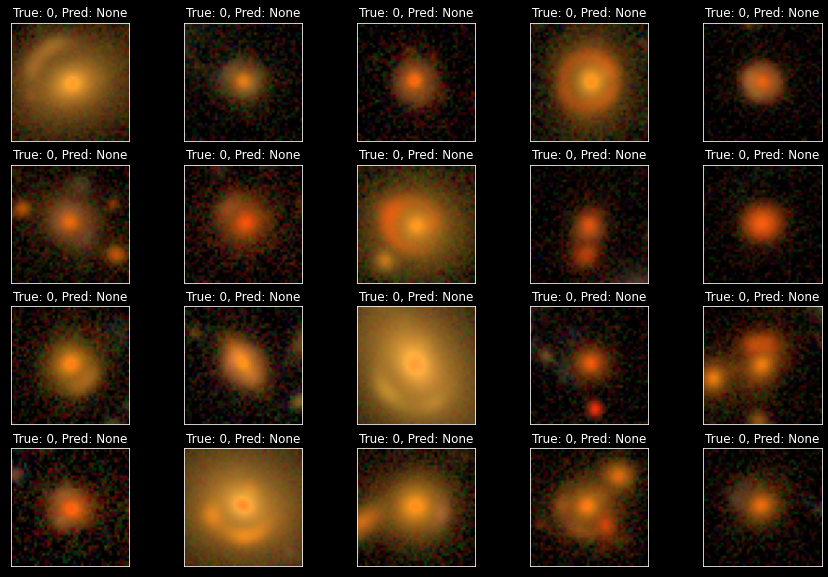

Negative cases


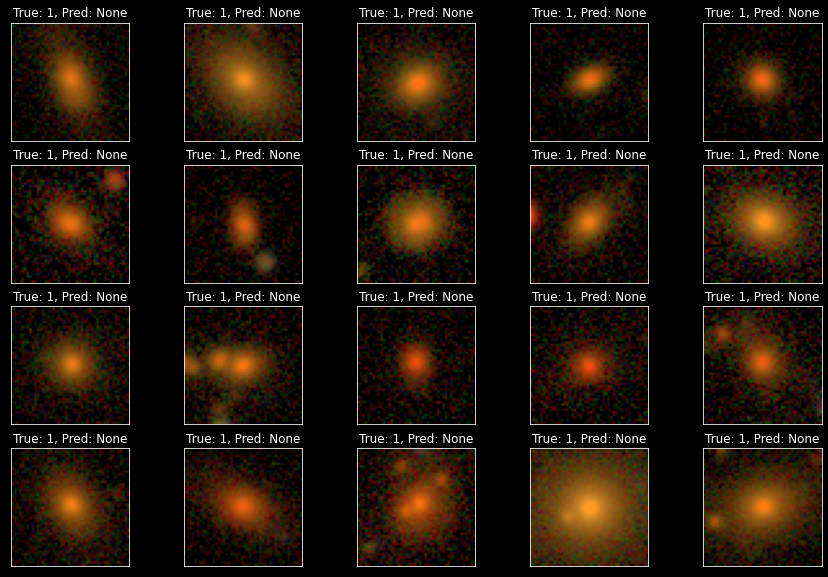

In [10]:
def make_plot_all(objects, true_labels, pred_labels, title):
    plt.figure(figsize=(15,10))
    print(title)
    for i in range(20):
        plot_title = 'True: {}, Pred: {}'.format(true_labels[i], pred_labels[i])
        plt.subplot(4,5,i+1)
        plt.title(plot_title)
        rgb = make_lupton_rgb(objects[i][2], objects[i][1], objects[i][0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    if(os.path.exists(path_im) == False):
            os.makedirs(path_im)
    plt.savefig(path_im + '/' + title + '.png', bbox_inches='tight')
    plt.show()   

title = 'Positive cases'
idx = random.sample(range(len(sim)), 20)
objects = sim[idx]
true_labels = np.zeros(20, dtype = np.int64)
pre_labels = [None]*len(sim)
make_plot_all(objects, true_labels, pre_labels, title)

title = 'Negative cases'
idx = random.sample(range(len(cutouts)), 20)
objects = cutouts[idx]
true_labels = np.ones(20, dtype = np.int64)
pre_labels = [None]*len(cutouts)
make_plot_all(objects, true_labels, pre_labels, title)

In [11]:
# Train the CNN
name = str(num_exp) + '/' + 'model.pt'#'model.pt'#'other.pt' 
name_saved_model = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/' + name

print(name_saved_model)
             
cnn = train_cnn(cnn, 
				train_dataloader, 
				train_dataset=train_dataset,
				test_dataset=test_dataset,
				validation_size=200, #100
				number_of_training_epochs=90, #150
				monitor=True,
               name=name_saved_model)

/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/30/model.pt
Epoch: 1 Batch: 1  | Training Accuracy: 0.475 -- Validation Accuracy: 0.505 -- Loss: 5.370
Epoch: 1 Batch: 201  | Training Accuracy: 0.510 -- Validation Accuracy: 0.490 -- Loss: 0.628


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 2 Batch: 1  | Training Accuracy: 0.535 -- Validation Accuracy: 0.615 -- Loss: 0.631
Epoch: 2 Batch: 201  | Training Accuracy: 0.585 -- Validation Accuracy: 0.540 -- Loss: 0.912


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 3 Batch: 1  | Training Accuracy: 0.510 -- Validation Accuracy: 0.555 -- Loss: 0.632
Epoch: 3 Batch: 201  | Training Accuracy: 0.600 -- Validation Accuracy: 0.590 -- Loss: 0.718


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 4 Batch: 1  | Training Accuracy: 0.560 -- Validation Accuracy: 0.555 -- Loss: 0.638
Epoch: 4 Batch: 201  | Training Accuracy: 0.560 -- Validation Accuracy: 0.635 -- Loss: 0.636


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 5 Batch: 1  | Training Accuracy: 0.595 -- Validation Accuracy: 0.645 -- Loss: 0.562
Epoch: 5 Batch: 201  | Training Accuracy: 0.565 -- Validation Accuracy: 0.635 -- Loss: 0.673


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 6 Batch: 1  | Training Accuracy: 0.605 -- Validation Accuracy: 0.620 -- Loss: 0.708
Epoch: 6 Batch: 201  | Training Accuracy: 0.640 -- Validation Accuracy: 0.640 -- Loss: 0.643


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 7 Batch: 1  | Training Accuracy: 0.655 -- Validation Accuracy: 0.680 -- Loss: 0.539
Epoch: 7 Batch: 201  | Training Accuracy: 0.700 -- Validation Accuracy: 0.730 -- Loss: 0.663


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 8 Batch: 1  | Training Accuracy: 0.700 -- Validation Accuracy: 0.680 -- Loss: 0.698
Epoch: 8 Batch: 201  | Training Accuracy: 0.675 -- Validation Accuracy: 0.695 -- Loss: 0.629


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 9 Batch: 1  | Training Accuracy: 0.640 -- Validation Accuracy: 0.715 -- Loss: 0.585
Epoch: 9 Batch: 201  | Training Accuracy: 0.740 -- Validation Accuracy: 0.740 -- Loss: 0.539


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 10 Batch: 1  | Training Accuracy: 0.740 -- Validation Accuracy: 0.720 -- Loss: 0.570
Epoch: 10 Batch: 201  | Training Accuracy: 0.750 -- Validation Accuracy: 0.735 -- Loss: 0.420


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 11 Batch: 1  | Training Accuracy: 0.765 -- Validation Accuracy: 0.730 -- Loss: 0.567
Epoch: 11 Batch: 201  | Training Accuracy: 0.745 -- Validation Accuracy: 0.730 -- Loss: 0.363


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 12 Batch: 1  | Training Accuracy: 0.745 -- Validation Accuracy: 0.715 -- Loss: 0.673
Epoch: 12 Batch: 201  | Training Accuracy: 0.760 -- Validation Accuracy: 0.780 -- Loss: 0.463


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 13 Batch: 1  | Training Accuracy: 0.730 -- Validation Accuracy: 0.720 -- Loss: 0.366
Epoch: 13 Batch: 201  | Training Accuracy: 0.770 -- Validation Accuracy: 0.755 -- Loss: 0.648


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 14 Batch: 1  | Training Accuracy: 0.780 -- Validation Accuracy: 0.785 -- Loss: 0.455
Epoch: 14 Batch: 201  | Training Accuracy: 0.795 -- Validation Accuracy: 0.770 -- Loss: 0.771


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 15 Batch: 1  | Training Accuracy: 0.785 -- Validation Accuracy: 0.770 -- Loss: 0.404
Epoch: 15 Batch: 201  | Training Accuracy: 0.795 -- Validation Accuracy: 0.780 -- Loss: 0.493


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 16 Batch: 1  | Training Accuracy: 0.790 -- Validation Accuracy: 0.835 -- Loss: 0.471
Epoch: 16 Batch: 201  | Training Accuracy: 0.780 -- Validation Accuracy: 0.775 -- Loss: 0.412


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 17 Batch: 1  | Training Accuracy: 0.790 -- Validation Accuracy: 0.795 -- Loss: 0.405
Epoch: 17 Batch: 201  | Training Accuracy: 0.785 -- Validation Accuracy: 0.800 -- Loss: 0.276


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 18 Batch: 1  | Training Accuracy: 0.780 -- Validation Accuracy: 0.805 -- Loss: 0.464
Epoch: 18 Batch: 201  | Training Accuracy: 0.795 -- Validation Accuracy: 0.800 -- Loss: 0.597


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 19 Batch: 1  | Training Accuracy: 0.765 -- Validation Accuracy: 0.740 -- Loss: 0.280
Epoch: 19 Batch: 201  | Training Accuracy: 0.790 -- Validation Accuracy: 0.805 -- Loss: 0.530


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 20 Batch: 1  | Training Accuracy: 0.815 -- Validation Accuracy: 0.825 -- Loss: 0.468
Epoch: 20 Batch: 201  | Training Accuracy: 0.840 -- Validation Accuracy: 0.845 -- Loss: 0.449


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 21 Batch: 1  | Training Accuracy: 0.795 -- Validation Accuracy: 0.820 -- Loss: 0.325
Epoch: 21 Batch: 201  | Training Accuracy: 0.815 -- Validation Accuracy: 0.790 -- Loss: 0.422


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 22 Batch: 1  | Training Accuracy: 0.830 -- Validation Accuracy: 0.810 -- Loss: 0.446
Epoch: 22 Batch: 201  | Training Accuracy: 0.845 -- Validation Accuracy: 0.855 -- Loss: 0.338


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 23 Batch: 1  | Training Accuracy: 0.810 -- Validation Accuracy: 0.825 -- Loss: 0.362
Epoch: 23 Batch: 201  | Training Accuracy: 0.840 -- Validation Accuracy: 0.820 -- Loss: 0.321


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 24 Batch: 1  | Training Accuracy: 0.850 -- Validation Accuracy: 0.855 -- Loss: 0.462
Epoch: 24 Batch: 201  | Training Accuracy: 0.825 -- Validation Accuracy: 0.820 -- Loss: 0.445


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 25 Batch: 1  | Training Accuracy: 0.840 -- Validation Accuracy: 0.830 -- Loss: 0.317
Epoch: 25 Batch: 201  | Training Accuracy: 0.825 -- Validation Accuracy: 0.865 -- Loss: 0.314


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 26 Batch: 1  | Training Accuracy: 0.800 -- Validation Accuracy: 0.790 -- Loss: 0.415
Epoch: 26 Batch: 201  | Training Accuracy: 0.820 -- Validation Accuracy: 0.845 -- Loss: 0.370


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 27 Batch: 1  | Training Accuracy: 0.850 -- Validation Accuracy: 0.855 -- Loss: 0.494
Epoch: 27 Batch: 201  | Training Accuracy: 0.840 -- Validation Accuracy: 0.805 -- Loss: 0.435


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 28 Batch: 1  | Training Accuracy: 0.865 -- Validation Accuracy: 0.840 -- Loss: 0.204
Epoch: 28 Batch: 201  | Training Accuracy: 0.855 -- Validation Accuracy: 0.840 -- Loss: 0.249


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 29 Batch: 1  | Training Accuracy: 0.855 -- Validation Accuracy: 0.825 -- Loss: 0.409
Epoch: 29 Batch: 201  | Training Accuracy: 0.855 -- Validation Accuracy: 0.890 -- Loss: 0.373


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 30 Batch: 1  | Training Accuracy: 0.845 -- Validation Accuracy: 0.830 -- Loss: 0.440
Epoch: 30 Batch: 201  | Training Accuracy: 0.875 -- Validation Accuracy: 0.860 -- Loss: 0.248


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 31 Batch: 1  | Training Accuracy: 0.875 -- Validation Accuracy: 0.835 -- Loss: 0.584
Epoch: 31 Batch: 201  | Training Accuracy: 0.850 -- Validation Accuracy: 0.860 -- Loss: 0.348


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 32 Batch: 1  | Training Accuracy: 0.840 -- Validation Accuracy: 0.840 -- Loss: 0.270
Epoch: 32 Batch: 201  | Training Accuracy: 0.830 -- Validation Accuracy: 0.835 -- Loss: 0.223


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 33 Batch: 1  | Training Accuracy: 0.880 -- Validation Accuracy: 0.870 -- Loss: 0.587
Epoch: 33 Batch: 201  | Training Accuracy: 0.880 -- Validation Accuracy: 0.860 -- Loss: 0.152


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 34 Batch: 1  | Training Accuracy: 0.865 -- Validation Accuracy: 0.855 -- Loss: 0.243
Epoch: 34 Batch: 201  | Training Accuracy: 0.880 -- Validation Accuracy: 0.880 -- Loss: 0.338


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 35 Batch: 1  | Training Accuracy: 0.850 -- Validation Accuracy: 0.885 -- Loss: 0.126
Epoch: 35 Batch: 201  | Training Accuracy: 0.885 -- Validation Accuracy: 0.865 -- Loss: 0.160


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 36 Batch: 1  | Training Accuracy: 0.895 -- Validation Accuracy: 0.835 -- Loss: 0.176
Epoch: 36 Batch: 201  | Training Accuracy: 0.910 -- Validation Accuracy: 0.845 -- Loss: 0.164


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 37 Batch: 1  | Training Accuracy: 0.900 -- Validation Accuracy: 0.870 -- Loss: 0.199
Epoch: 37 Batch: 201  | Training Accuracy: 0.865 -- Validation Accuracy: 0.845 -- Loss: 0.166


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 38 Batch: 1  | Training Accuracy: 0.875 -- Validation Accuracy: 0.840 -- Loss: 0.077
Epoch: 38 Batch: 201  | Training Accuracy: 0.900 -- Validation Accuracy: 0.885 -- Loss: 0.074


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 39 Batch: 1  | Training Accuracy: 0.885 -- Validation Accuracy: 0.855 -- Loss: 0.100
Epoch: 39 Batch: 201  | Training Accuracy: 0.900 -- Validation Accuracy: 0.865 -- Loss: 0.136


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 40 Batch: 1  | Training Accuracy: 0.865 -- Validation Accuracy: 0.860 -- Loss: 0.255
Epoch: 40 Batch: 201  | Training Accuracy: 0.905 -- Validation Accuracy: 0.860 -- Loss: 0.236


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 41 Batch: 1  | Training Accuracy: 0.890 -- Validation Accuracy: 0.860 -- Loss: 0.052
Epoch: 41 Batch: 201  | Training Accuracy: 0.895 -- Validation Accuracy: 0.845 -- Loss: 0.095


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 42 Batch: 1  | Training Accuracy: 0.910 -- Validation Accuracy: 0.845 -- Loss: 0.099
Epoch: 42 Batch: 201  | Training Accuracy: 0.895 -- Validation Accuracy: 0.865 -- Loss: 0.081


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 43 Batch: 1  | Training Accuracy: 0.895 -- Validation Accuracy: 0.875 -- Loss: 0.209
Epoch: 43 Batch: 201  | Training Accuracy: 0.925 -- Validation Accuracy: 0.865 -- Loss: 0.112


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 44 Batch: 1  | Training Accuracy: 0.885 -- Validation Accuracy: 0.840 -- Loss: 0.425
Epoch: 44 Batch: 201  | Training Accuracy: 0.915 -- Validation Accuracy: 0.870 -- Loss: 0.035


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 45 Batch: 1  | Training Accuracy: 0.915 -- Validation Accuracy: 0.870 -- Loss: 0.110
Epoch: 45 Batch: 201  | Training Accuracy: 0.885 -- Validation Accuracy: 0.865 -- Loss: 0.300


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 46 Batch: 1  | Training Accuracy: 0.930 -- Validation Accuracy: 0.860 -- Loss: 0.122
Epoch: 46 Batch: 201  | Training Accuracy: 0.905 -- Validation Accuracy: 0.870 -- Loss: 0.311


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 47 Batch: 1  | Training Accuracy: 0.905 -- Validation Accuracy: 0.880 -- Loss: 0.120
Epoch: 47 Batch: 201  | Training Accuracy: 0.895 -- Validation Accuracy: 0.870 -- Loss: 0.135


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 48 Batch: 1  | Training Accuracy: 0.920 -- Validation Accuracy: 0.895 -- Loss: 0.052
Epoch: 48 Batch: 201  | Training Accuracy: 0.920 -- Validation Accuracy: 0.870 -- Loss: 0.043


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 49 Batch: 1  | Training Accuracy: 0.935 -- Validation Accuracy: 0.880 -- Loss: 0.156
Epoch: 49 Batch: 201  | Training Accuracy: 0.895 -- Validation Accuracy: 0.835 -- Loss: 0.198


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 50 Batch: 1  | Training Accuracy: 0.900 -- Validation Accuracy: 0.870 -- Loss: 0.049
Epoch: 50 Batch: 201  | Training Accuracy: 0.945 -- Validation Accuracy: 0.885 -- Loss: 0.031


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 51 Batch: 1  | Training Accuracy: 0.920 -- Validation Accuracy: 0.885 -- Loss: 0.250
Epoch: 51 Batch: 201  | Training Accuracy: 0.920 -- Validation Accuracy: 0.870 -- Loss: 0.220


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 52 Batch: 1  | Training Accuracy: 0.935 -- Validation Accuracy: 0.890 -- Loss: 0.112
Epoch: 52 Batch: 201  | Training Accuracy: 0.960 -- Validation Accuracy: 0.845 -- Loss: 0.118


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 53 Batch: 1  | Training Accuracy: 0.925 -- Validation Accuracy: 0.840 -- Loss: 0.399
Epoch: 53 Batch: 201  | Training Accuracy: 0.925 -- Validation Accuracy: 0.845 -- Loss: 0.136


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 54 Batch: 1  | Training Accuracy: 0.920 -- Validation Accuracy: 0.875 -- Loss: 0.019
Epoch: 54 Batch: 201  | Training Accuracy: 0.935 -- Validation Accuracy: 0.870 -- Loss: 0.285


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 55 Batch: 1  | Training Accuracy: 0.955 -- Validation Accuracy: 0.860 -- Loss: 0.060
Epoch: 55 Batch: 201  | Training Accuracy: 0.960 -- Validation Accuracy: 0.870 -- Loss: 0.104


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 56 Batch: 1  | Training Accuracy: 0.950 -- Validation Accuracy: 0.870 -- Loss: 0.022
Epoch: 56 Batch: 201  | Training Accuracy: 0.945 -- Validation Accuracy: 0.855 -- Loss: 0.132


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 57 Batch: 1  | Training Accuracy: 0.955 -- Validation Accuracy: 0.840 -- Loss: 0.077
Epoch: 57 Batch: 201  | Training Accuracy: 0.930 -- Validation Accuracy: 0.865 -- Loss: 0.133


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 58 Batch: 1  | Training Accuracy: 0.910 -- Validation Accuracy: 0.865 -- Loss: 0.235
Epoch: 58 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.865 -- Loss: 0.094


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 59 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.860 -- Loss: 0.150
Epoch: 59 Batch: 201  | Training Accuracy: 0.945 -- Validation Accuracy: 0.880 -- Loss: 0.235


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 60 Batch: 1  | Training Accuracy: 0.930 -- Validation Accuracy: 0.835 -- Loss: 0.031
Epoch: 60 Batch: 201  | Training Accuracy: 0.930 -- Validation Accuracy: 0.860 -- Loss: 0.040


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 61 Batch: 1  | Training Accuracy: 0.930 -- Validation Accuracy: 0.875 -- Loss: 0.008
Epoch: 61 Batch: 201  | Training Accuracy: 0.935 -- Validation Accuracy: 0.835 -- Loss: 0.111


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 62 Batch: 1  | Training Accuracy: 0.940 -- Validation Accuracy: 0.860 -- Loss: 0.303
Epoch: 62 Batch: 201  | Training Accuracy: 0.955 -- Validation Accuracy: 0.860 -- Loss: 0.129


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 63 Batch: 1  | Training Accuracy: 0.965 -- Validation Accuracy: 0.885 -- Loss: 0.080
Epoch: 63 Batch: 201  | Training Accuracy: 0.960 -- Validation Accuracy: 0.855 -- Loss: 0.084


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 64 Batch: 1  | Training Accuracy: 0.950 -- Validation Accuracy: 0.860 -- Loss: 0.271
Epoch: 64 Batch: 201  | Training Accuracy: 0.970 -- Validation Accuracy: 0.875 -- Loss: 0.056


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 65 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.845 -- Loss: 0.020
Epoch: 65 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.885 -- Loss: 0.104


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 66 Batch: 1  | Training Accuracy: 0.955 -- Validation Accuracy: 0.870 -- Loss: 0.186
Epoch: 66 Batch: 201  | Training Accuracy: 0.965 -- Validation Accuracy: 0.875 -- Loss: 0.145


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 67 Batch: 1  | Training Accuracy: 0.980 -- Validation Accuracy: 0.885 -- Loss: 0.001
Epoch: 67 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.860 -- Loss: 0.028


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 68 Batch: 1  | Training Accuracy: 0.980 -- Validation Accuracy: 0.830 -- Loss: 0.021
Epoch: 68 Batch: 201  | Training Accuracy: 0.945 -- Validation Accuracy: 0.860 -- Loss: 0.071


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 69 Batch: 1  | Training Accuracy: 0.955 -- Validation Accuracy: 0.835 -- Loss: 0.045
Epoch: 69 Batch: 201  | Training Accuracy: 0.940 -- Validation Accuracy: 0.850 -- Loss: 0.148


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 70 Batch: 1  | Training Accuracy: 0.975 -- Validation Accuracy: 0.890 -- Loss: 0.059
Epoch: 70 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.850 -- Loss: 0.005


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 71 Batch: 1  | Training Accuracy: 0.975 -- Validation Accuracy: 0.860 -- Loss: 0.016
Epoch: 71 Batch: 201  | Training Accuracy: 0.970 -- Validation Accuracy: 0.870 -- Loss: 0.009


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 72 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.885 -- Loss: 0.045
Epoch: 72 Batch: 201  | Training Accuracy: 0.985 -- Validation Accuracy: 0.870 -- Loss: 0.062


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 73 Batch: 1  | Training Accuracy: 0.980 -- Validation Accuracy: 0.860 -- Loss: 0.006
Epoch: 73 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.875 -- Loss: 0.029


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 74 Batch: 1  | Training Accuracy: 0.940 -- Validation Accuracy: 0.860 -- Loss: 0.041
Epoch: 74 Batch: 201  | Training Accuracy: 0.965 -- Validation Accuracy: 0.845 -- Loss: 0.011


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 75 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.845 -- Loss: 0.094
Epoch: 75 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.860 -- Loss: 0.028


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 76 Batch: 1  | Training Accuracy: 0.910 -- Validation Accuracy: 0.845 -- Loss: 0.004
Epoch: 76 Batch: 201  | Training Accuracy: 0.965 -- Validation Accuracy: 0.855 -- Loss: 0.076


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 77 Batch: 1  | Training Accuracy: 0.960 -- Validation Accuracy: 0.865 -- Loss: 0.047
Epoch: 77 Batch: 201  | Training Accuracy: 0.985 -- Validation Accuracy: 0.855 -- Loss: 0.008


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 78 Batch: 1  | Training Accuracy: 0.975 -- Validation Accuracy: 0.865 -- Loss: 0.047
Epoch: 78 Batch: 201  | Training Accuracy: 0.970 -- Validation Accuracy: 0.870 -- Loss: 0.054


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 79 Batch: 1  | Training Accuracy: 0.980 -- Validation Accuracy: 0.860 -- Loss: 0.026
Epoch: 79 Batch: 201  | Training Accuracy: 0.985 -- Validation Accuracy: 0.855 -- Loss: 0.040


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 80 Batch: 1  | Training Accuracy: 0.990 -- Validation Accuracy: 0.865 -- Loss: 0.051
Epoch: 80 Batch: 201  | Training Accuracy: 0.990 -- Validation Accuracy: 0.865 -- Loss: 0.151


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 81 Batch: 1  | Training Accuracy: 0.960 -- Validation Accuracy: 0.865 -- Loss: 0.161
Epoch: 81 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.865 -- Loss: 0.027


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 82 Batch: 1  | Training Accuracy: 0.985 -- Validation Accuracy: 0.870 -- Loss: 0.029
Epoch: 82 Batch: 201  | Training Accuracy: 0.935 -- Validation Accuracy: 0.760 -- Loss: 0.190


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 83 Batch: 1  | Training Accuracy: 0.960 -- Validation Accuracy: 0.855 -- Loss: 0.180
Epoch: 83 Batch: 201  | Training Accuracy: 0.945 -- Validation Accuracy: 0.835 -- Loss: 0.157


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 84 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.860 -- Loss: 0.031
Epoch: 84 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.835 -- Loss: 0.041


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 85 Batch: 1  | Training Accuracy: 0.970 -- Validation Accuracy: 0.830 -- Loss: 0.027
Epoch: 85 Batch: 201  | Training Accuracy: 0.985 -- Validation Accuracy: 0.880 -- Loss: 0.040


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 86 Batch: 1  | Training Accuracy: 0.985 -- Validation Accuracy: 0.855 -- Loss: 0.090
Epoch: 86 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.835 -- Loss: 0.097


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 87 Batch: 1  | Training Accuracy: 0.965 -- Validation Accuracy: 0.870 -- Loss: 0.011
Epoch: 87 Batch: 201  | Training Accuracy: 0.970 -- Validation Accuracy: 0.875 -- Loss: 0.020


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 88 Batch: 1  | Training Accuracy: 0.995 -- Validation Accuracy: 0.835 -- Loss: 0.021
Epoch: 88 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.855 -- Loss: 0.154


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 89 Batch: 1  | Training Accuracy: 0.985 -- Validation Accuracy: 0.855 -- Loss: 0.005
Epoch: 89 Batch: 201  | Training Accuracy: 0.975 -- Validation Accuracy: 0.840 -- Loss: 0.031


[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:206] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 90 Batch: 1  | Training Accuracy: 0.985 -- Validation Accuracy: 0.845 -- Loss: 0.017
Epoch: 90 Batch: 201  | Training Accuracy: 0.970 -- Validation Accuracy: 0.870 -- Loss: 0.109


In [12]:
name = str(num_exp) + '/' + 'model.pt'#'model.pt'#'other.pt' 
name_saved_model = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/' + name #'model.pt'
CNN_test = torch.load(name_saved_model)
print(CNN_test.validation_acc[-1])

0.895


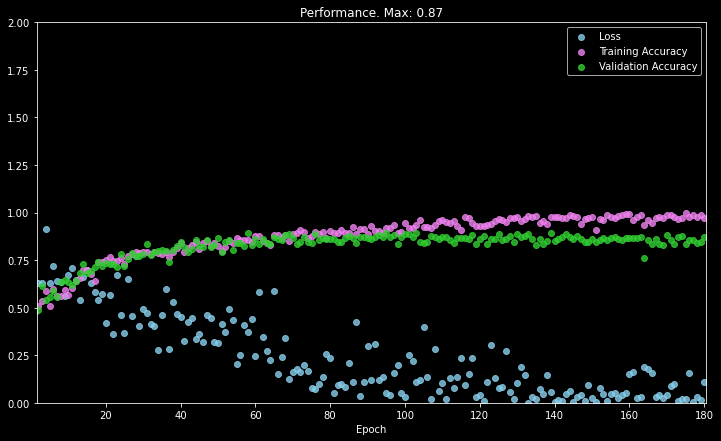

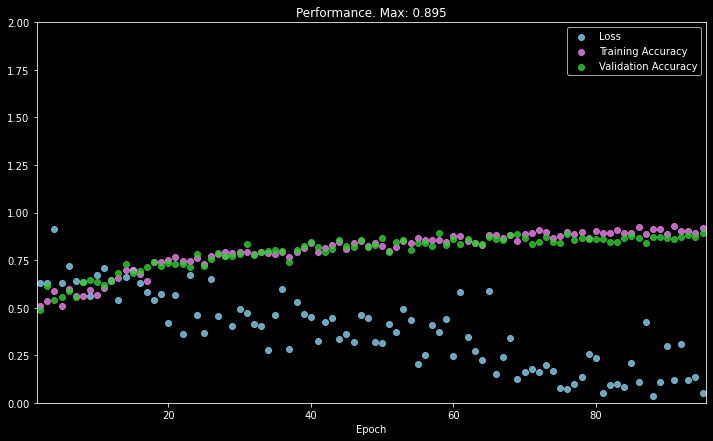

In [13]:
#plot learning rate
plot_performance(cnn)

plot_performance(CNN_test)

cnn = CNN_test

In [14]:
# Use the CNN to classify your whole test dataset
cnn.eval()

non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

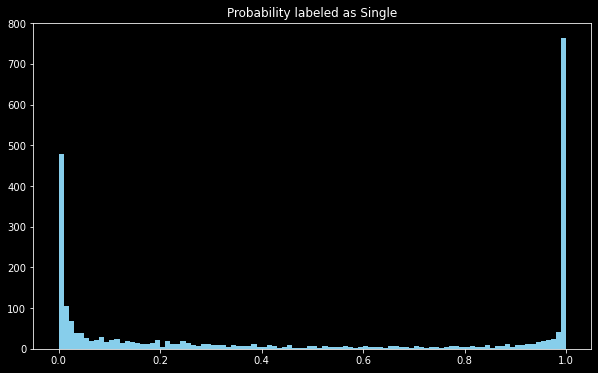

In [15]:
m = nn.Softmax(dim=1) 
prob = (m(non_binary_predictions))
prob = prob[:,0].detach().numpy()

plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob, 100, color = "skyblue")
plt.savefig(path_im + '/' + 'Prob_Pos Distribution.png', bbox_inches='tight')
plt.show()

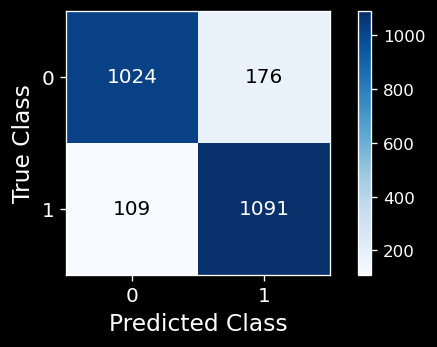

In [16]:
# Plot a confusion matrix of your results
classes = np.unique(labels)
plot_confusion_matrix(test_labels, test_predictions, classes)

In [17]:
ind_lenses_w, ind_lenses_r = [], []
ind_neg_w, ind_neg_r = [], []
for i in range(len(test_labels)):
    if(test_predictions[i] != test_labels[i] and test_labels[i] == 0):
        ind_lenses_w.append(i)
    elif(test_predictions[i] != test_labels[i] and test_labels[i] == 1):
        ind_neg_w.append(i)
    elif(test_predictions[i] == test_labels[i] and test_labels[i] == 0):
            ind_lenses_r.append(i)
    else:
        ind_neg_r.append(i)

Wrong lenses


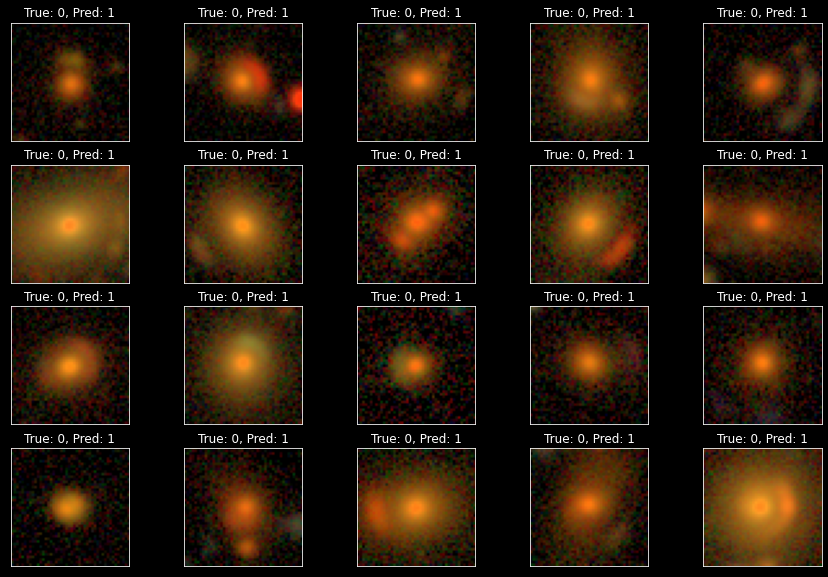

Wrong negatives


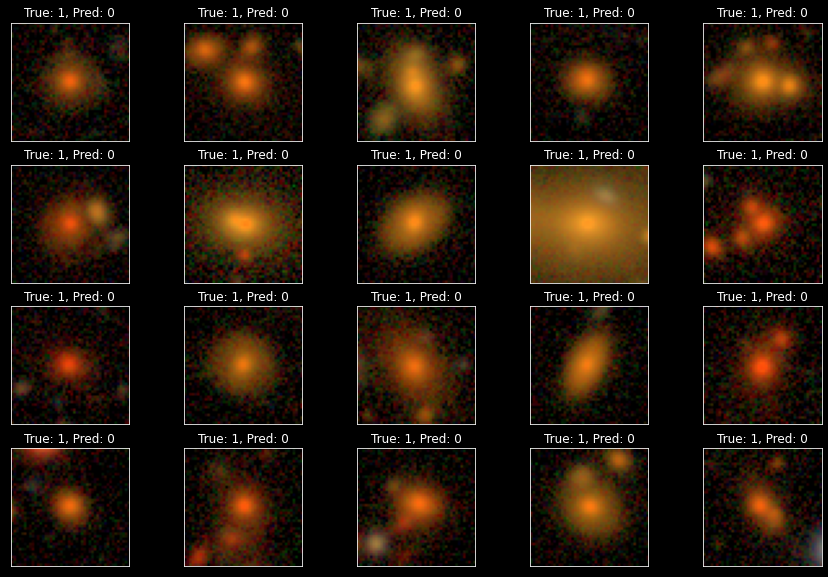

Right lenses


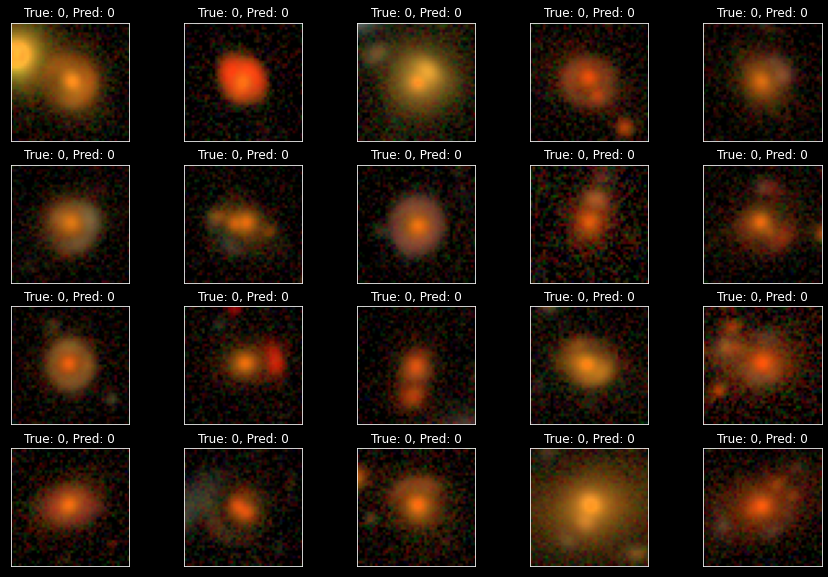

Right Negatives


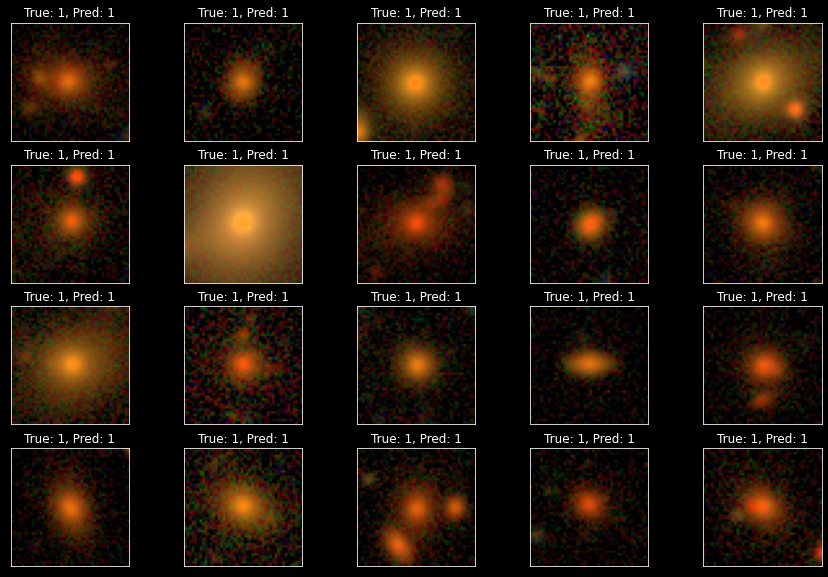

In [18]:
lenses_wrong = test_dataset.images[ind_lenses_w]
lenses_right = test_dataset.images[ind_lenses_r]
neg_wrong = test_dataset.images[ind_neg_w]
neg_right = test_dataset.images[ind_neg_r]

data_wrong_lenses = test_data[ind_lenses_w]
data_right_lenses = test_data[ind_lenses_r]


names  = ['zl/z1', 'm', 'iso', 'E', 'Magni 1']
titles = ['z_l:z_1', 'Lensed Apparent Magnitude', 'Isolation', 'Einstein Radius', 'Magnification S1']


title = 'Wrong lenses'
idx = random.sample(range(len(lenses_wrong)), 20)
true_labels = test_labels[ind_lenses_w] # The true label
pred_labels = test_predictions[ind_lenses_w]
objects = lenses_wrong[idx]
make_plot_all(objects, true_labels, pred_labels, title)

title = 'Wrong negatives'
idx = random.sample(range(len(neg_wrong)), 20)
true_labels = test_labels[ind_neg_w] # The true label
pred_labels = test_predictions[ind_neg_w]
objects = neg_wrong[idx]
make_plot_all(objects, true_labels, pred_labels, title)

title = 'Right lenses'
idx = random.sample(range(len(lenses_right)), 20)
true_labels = test_labels[ind_lenses_r] # The true label
pred_labels = test_predictions[ind_lenses_r]
objects = lenses_right[idx]
make_plot_all(objects, true_labels, pred_labels, title)

title = 'Right Negatives'
idx = random.sample(range(len(neg_right)), 20)
true_labels = test_labels[ind_neg_r] # The true label
pred_labels = test_predictions[ind_neg_r]
objects = neg_right[idx]
make_plot_all(objects, true_labels, pred_labels, title)

In [19]:
print(data_wrong_lenses.shape)
print(data_wrong_lenses[0])
print(data_wrong_lenses[0].shape)
print(type(data_wrong_lenses))
print(data_wrong_lenses.dtype.names)

(176,)
(0.47957237, 24.25785469, 0.41624114, 2.16517538, 2.58398568, 1.e+20)
()
<class 'numpy.recarray'>
('zl/z1', 'm', 'iso', 'E', 'Magni 1', 'eso')


                                                   Distributions


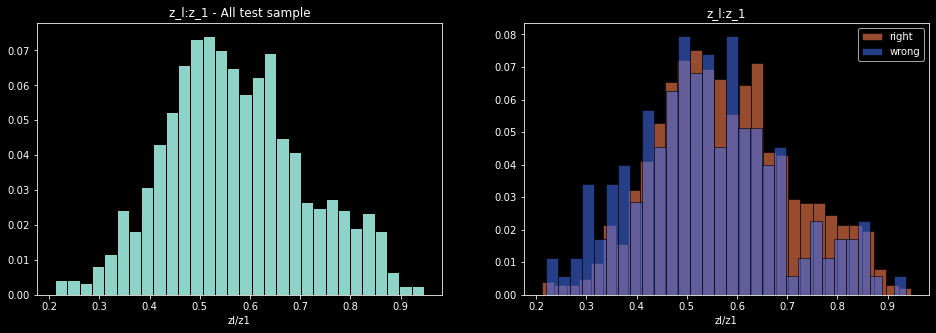

In [20]:
j = 0
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(titles[j] + ' - All test sample')
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
data_all = np.concatenate((data_wrong_lenses[names[j]], data_right_lenses[names[j]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(titles[j])
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
weights = np.ones_like(data_right_lenses[names[j]]) / len(data_right_lenses[names[j]])
plt.hist(data_right_lenses[names[j]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(data_wrong_lenses[names[j]]) / len(data_wrong_lenses[names[j]])
plt.hist(data_wrong_lenses[names[j]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()    
    
plt.savefig(path_im + '/Distribution_' + titles[j] + '.png', bbox_inches='tight')
plt.show()

                                                   Distributions


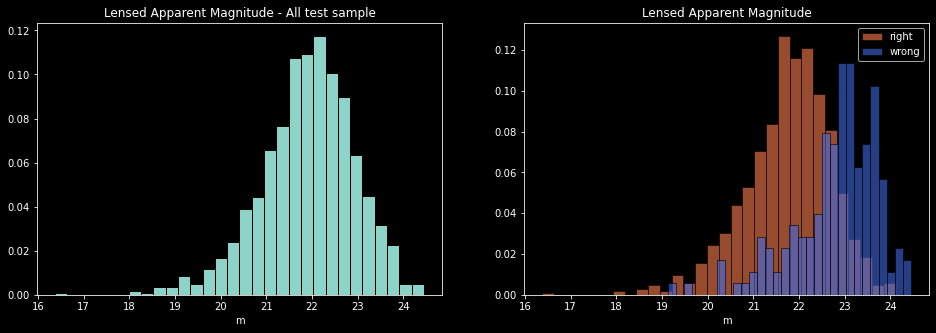

In [21]:
j = 1
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(titles[j] + ' - All test sample')
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
data_all = np.concatenate((data_wrong_lenses[names[j]], data_right_lenses[names[j]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(titles[j])
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
weights = np.ones_like(data_right_lenses[names[j]]) / len(data_right_lenses[names[j]])
plt.hist(data_right_lenses[names[j]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(data_wrong_lenses[names[j]]) / len(data_wrong_lenses[names[j]])
plt.hist(data_wrong_lenses[names[j]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()    
    
plt.savefig(path_im + '/Distribution_' + titles[j] + '.png', bbox_inches='tight')
plt.show()

                                                   Distributions


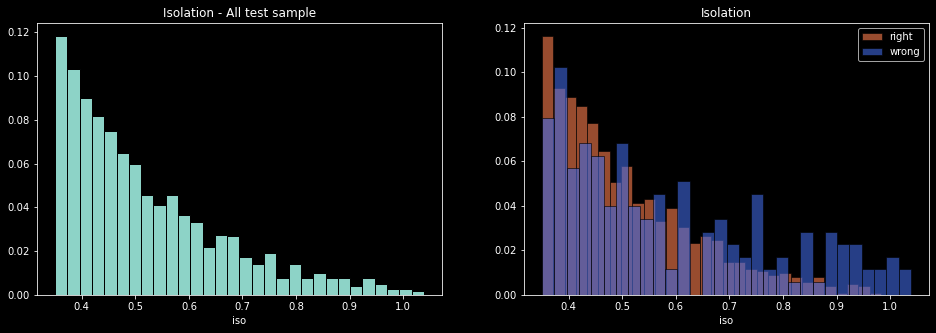

In [22]:
j = 2
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(titles[j] + ' - All test sample')
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
data_all = np.concatenate((data_wrong_lenses[names[j]], data_right_lenses[names[j]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(titles[j])
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
weights = np.ones_like(data_right_lenses[names[j]]) / len(data_right_lenses[names[j]])
plt.hist(data_right_lenses[names[j]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(data_wrong_lenses[names[j]]) / len(data_wrong_lenses[names[j]])
plt.hist(data_wrong_lenses[names[j]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()    
    
plt.savefig(path_im + '/Distribution_' + titles[j] + '.png', bbox_inches='tight')
plt.show()

                                                   Distributions


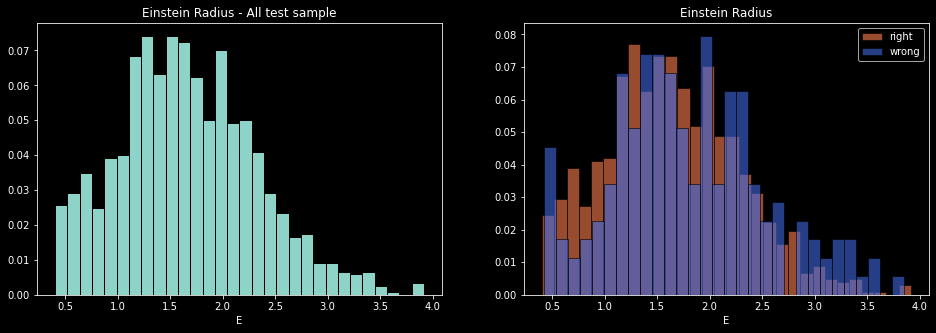

In [23]:
j = 3
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(titles[j] + ' - All test sample')
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
data_all = np.concatenate((data_wrong_lenses[names[j]], data_right_lenses[names[j]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(titles[j])
#plt.xlim(0.3, 2.8)
plt.xlabel(names[j])
weights = np.ones_like(data_right_lenses[names[j]]) / len(data_right_lenses[names[j]])
plt.hist(data_right_lenses[names[j]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(data_wrong_lenses[names[j]]) / len(data_wrong_lenses[names[j]])
plt.hist(data_wrong_lenses[names[j]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()    
    
plt.savefig(path_im + '/Distribution_' + titles[j] + '.png', bbox_inches='tight')
plt.show()

                                                   Distributions


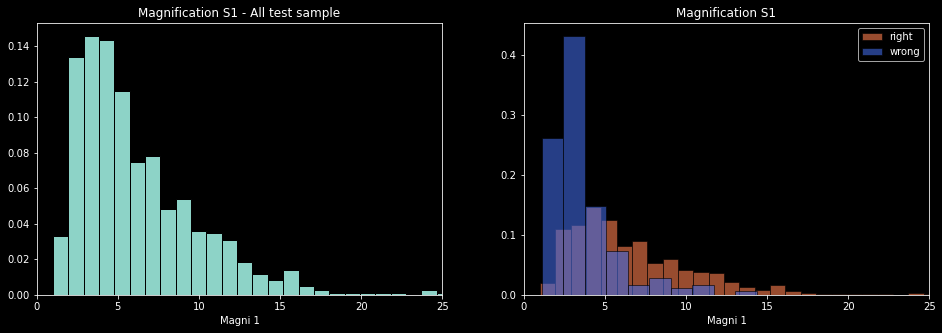

In [24]:
j = 4
print('                                                   Distributions')

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title(titles[j] + ' - All test sample')
plt.xlim(0., 25)
plt.xlabel(names[j])
data_all = np.concatenate((data_wrong_lenses[names[j]], data_right_lenses[names[j]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title(titles[j])
plt.xlim(0., 25)
plt.xlabel(names[j])
weights = np.ones_like(data_right_lenses[names[j]]) / len(data_right_lenses[names[j]])
plt.hist(data_right_lenses[names[j]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(data_wrong_lenses[names[j]]) / len(data_wrong_lenses[names[j]])
plt.hist(data_wrong_lenses[names[j]], 10, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()    
    
plt.savefig(path_im + '/Distribution_' + titles[j] + '.png', bbox_inches='tight')
plt.show()

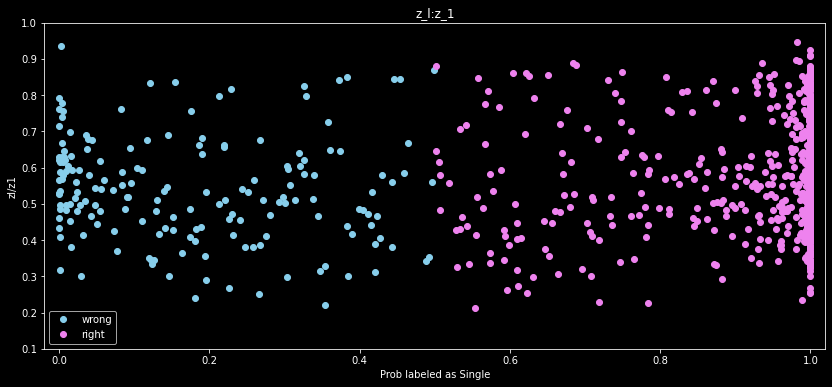

In [25]:
j = 0

plt.figure(figsize=(14,6)) 
plt.title(titles[j])
plt.xlabel('Prob labeled as Single')
plt.ylabel(names[j])
plt.xlim(-0.02, 1.02)
plt.ylim(0.1,1.)
plt.plot(prob[ind_lenses_w], data_wrong_lenses[names[j]], 'o', color = 'skyblue', label='wrong')
plt.plot(prob[ind_lenses_r], data_right_lenses[names[j]], 'o', color = 'violet', label='right')
plt.legend()

plt.savefig(path_im + '/Prob_Pos vs ' + titles[j] + '.png', bbox_inches='tight')
plt.show()

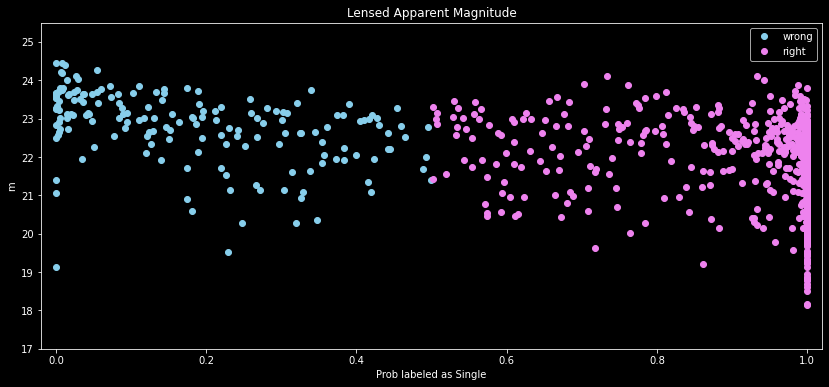

In [26]:
j = 1

plt.figure(figsize=(14,6)) 
plt.title(titles[j])
plt.xlabel('Prob labeled as Single')
plt.ylabel(names[j])
plt.xlim(-0.02, 1.02)
plt.ylim(17,25.5)
plt.plot(prob[ind_lenses_w], data_wrong_lenses[names[j]], 'o', color = 'skyblue', label='wrong')
plt.plot(prob[ind_lenses_r], data_right_lenses[names[j]], 'o', color = 'violet', label='right')
plt.legend()

plt.savefig(path_im + '/Prob_Pos vs ' + titles[j] + '.png', bbox_inches='tight')
plt.show()

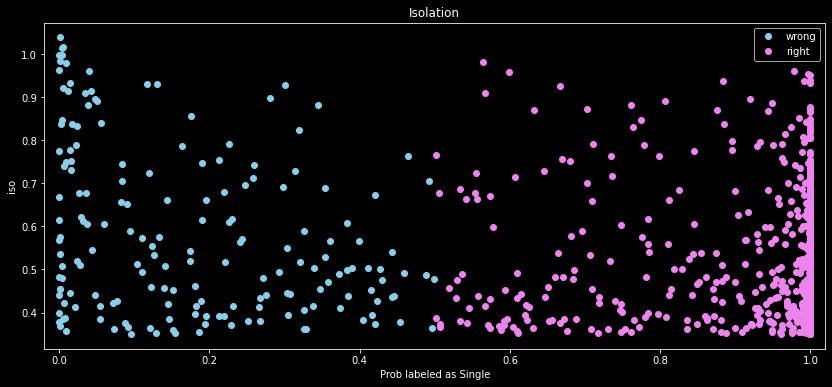

In [27]:
j = 2

plt.figure(figsize=(14,6)) 
plt.title(titles[j])
plt.xlabel('Prob labeled as Single')
plt.ylabel(names[j])
plt.xlim(-0.02, 1.02)
plt.plot(prob[ind_lenses_w], data_wrong_lenses[names[j]], 'o', color = 'skyblue', label='wrong')
plt.plot(prob[ind_lenses_r], data_right_lenses[names[j]], 'o', color = 'violet', label='right')
plt.legend()

plt.savefig(path_im + '/Prob_Pos vs ' + titles[j] + '.png', bbox_inches='tight')
plt.show()

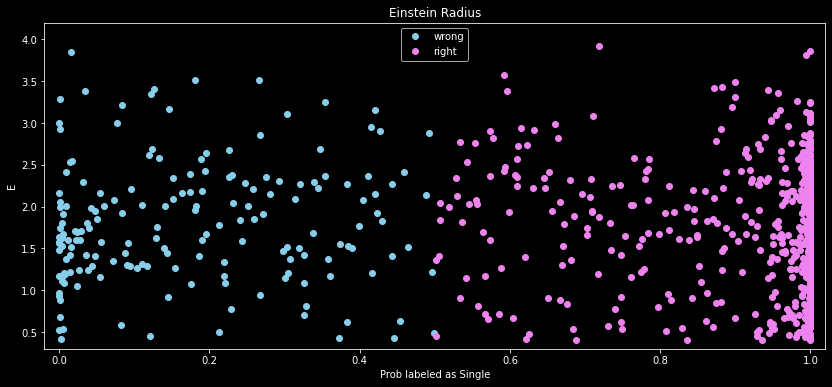

In [28]:
j = 3

plt.figure(figsize=(14,6)) 
plt.title(titles[j])
plt.xlabel('Prob labeled as Single')
plt.ylabel(names[j])
plt.xlim(-0.02, 1.02)
plt.ylim(0.3, 4.2)
plt.plot(prob[ind_lenses_w], data_wrong_lenses[names[j]], 'o', color = 'skyblue', label='wrong')
plt.plot(prob[ind_lenses_r], data_right_lenses[names[j]], 'o', color = 'violet', label='right')
plt.legend()

plt.savefig(path_im + '/Prob_Pos vs ' + titles[j] + '.png', bbox_inches='tight')
plt.show()

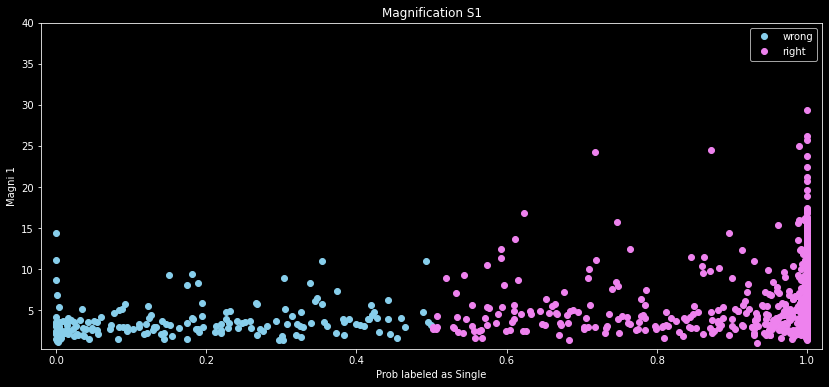

In [29]:
j = 4

plt.figure(figsize=(14,6)) 
plt.title(titles[j])
plt.xlabel('Prob labeled as Single')
plt.ylabel(names[j])
plt.xlim(-0.02, 1.02)
plt.ylim(0.3, 40)
plt.plot(prob[ind_lenses_w], data_wrong_lenses[names[j]], 'o', color = 'skyblue', label='wrong')
plt.plot(prob[ind_lenses_r], data_right_lenses[names[j]], 'o', color = 'violet', label='right')
plt.legend()

plt.savefig(path_im + '/Prob_Pos vs ' + titles[j] + '.png', bbox_inches='tight')
plt.show()

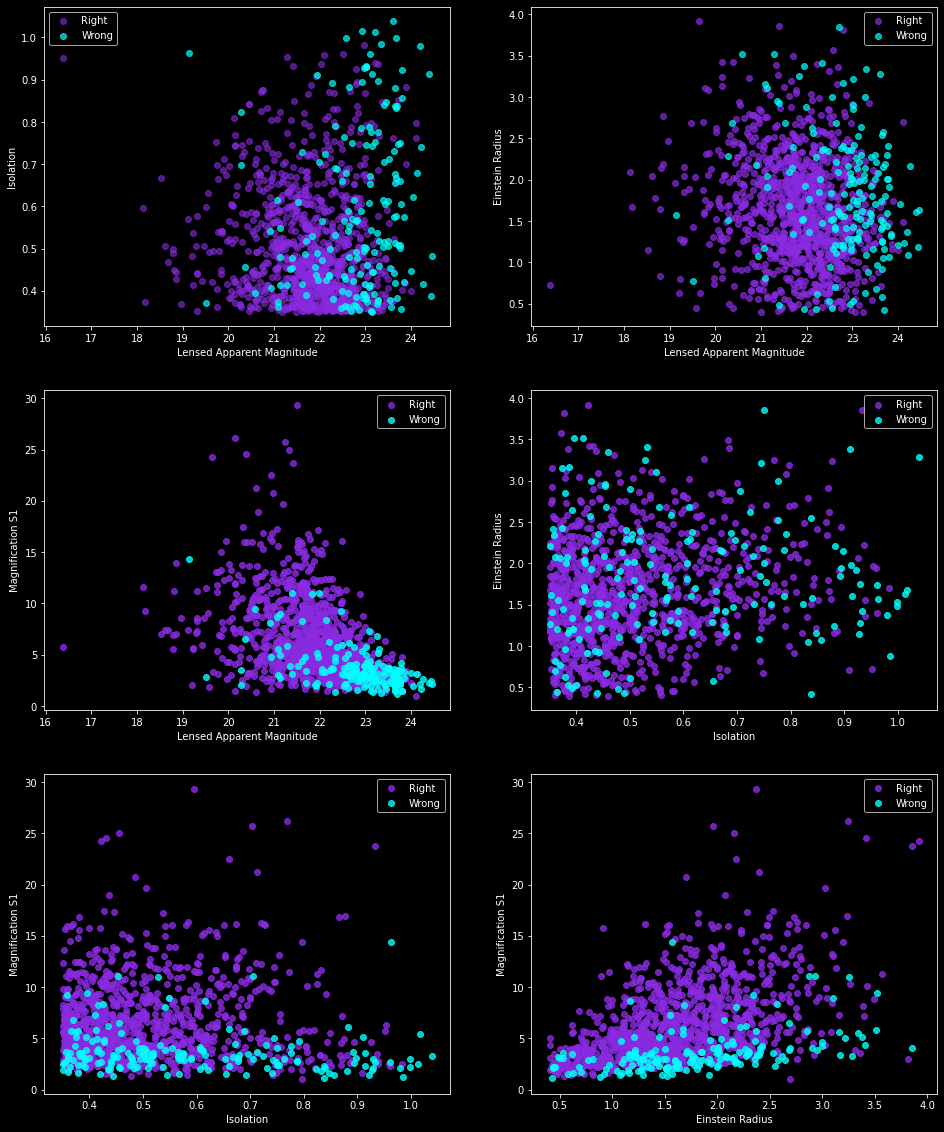

In [30]:
plt.figure(figsize=(16,20)) 

plt.subplot(3,2,1)
plt.xlabel(titles[1])
plt.ylabel(titles[2])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[1]], data_right_lenses[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(data_wrong_lenses[names[1]], data_wrong_lenses[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(3,2,2)
plt.xlabel(titles[1])
plt.ylabel(titles[3])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[1]], data_right_lenses[names[3]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(data_wrong_lenses[names[1]], data_wrong_lenses[names[3]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(3,2,3)
plt.xlabel(titles[1])
plt.ylabel(titles[4])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[1]], data_right_lenses[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(data_wrong_lenses[names[1]], data_wrong_lenses[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(3,2,4)
plt.xlabel(titles[2])
plt.ylabel(titles[3])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[2]], data_right_lenses[names[3]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(data_wrong_lenses[names[2]], data_wrong_lenses[names[3]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(3,2,5)
plt.xlabel(titles[2])
plt.ylabel(titles[4])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[2]], data_right_lenses[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(data_wrong_lenses[names[2]], data_wrong_lenses[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(3,2,6)
plt.xlabel(titles[3])
plt.ylabel(titles[4])
#plt.xlim(-0.05, 2.)
#plt.ylim(20,25.5)
plt.scatter(data_right_lenses[names[3]], data_right_lenses[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(data_wrong_lenses[names[3]], data_wrong_lenses[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.savefig(path_im + '/features.png', bbox_inches='tight')
plt.show()

In [31]:
bell -n say

In [32]:
bell -n notify